In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
path = "testcase-5-rev.dot"
nx_graph = nx.drawing.nx_pydot.read_dot(path)

In [4]:
print(nx_graph.nodes.get("a1"))
print(nx_graph.nodes.get("p1"))
print(nx_graph.in_edges("a1"))
print(nx_graph.get_edge_data('t1', 'a1'))

{'cost': '10', 'type': 'action'}
{'type': 'parallel'}
[('t1', 'a1')]
{0: {'range': '0..4'}}


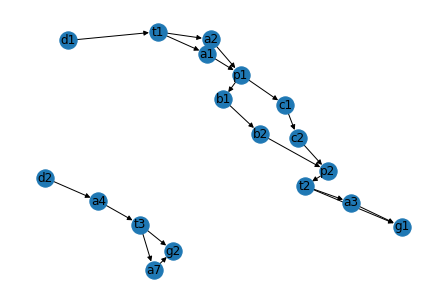

In [55]:
nx.draw(nx_graph, with_labels=True)
plt.show()

# Small Test using the Graphviz API for python

In [73]:
from graphviz import Digraph # We only need Digraph

class DotGraphCreator:
    __FORMAT = {
        'context': {
            'shape': 'oval',
            'fillcolor': 'grey',
            'fontcolor': 'black'
        },
        'action': {
            'shape': 'box',
            'fillcolor': 'deepskyblue',
            'fontcolor': 'black'
        },
        'decision': {
            'shape': 'diamond',
            'fillcolor': 'darkorange',
            'fontcolor': 'black'
        },
        'goal': {
            'shape': 'circle',
            'fillcolor': 'forestgreen',
            'fontcolor': 'white',
            'width': 0.1,
            'fontsize': 8
        },
        'parallel': {
            'shape': 'hexagon',
            'fillcolor': 'gold',
            'fontcolor': 'black',
            'height': 0.3,
            'width': 0.3,
            'fixedsize': True
        },
    }


    # disease = []
    # goal = []

    @classmethod
    def __create_node_label(cls, id, node_props):
        extra_label = f"<br/>[cost={node_props['cost']}]" if node_props['type'] == 'action' else ""
        return f"<<b>{id}</b>{extra_label}>"

    @classmethod
    def __create_edge_label(cls, in_node_props, edge_props):
        return f"{in_node_props['dataItem']}={edge_props['range']}" if in_node_props['type'] == 'decision' else ""

    @classmethod
    def create_dot_graph(cls, nx_graph):
        dot_graph = Digraph(name=nx_graph.graph['name'])

        disease = []
        goal = []
        nodes = nx_graph.nodes.values

        for n in nx_graph.nodes:

            # Check for a disease node
            if not nx_graph.in_edges(n):
                disease.append(n)

            # Check for a goal node
            if not nx_graph.out_edges(n):
                goal.append(n)


            node_props = nx_graph.nodes[n]
            node_format = cls.__FORMAT[node_props['type']]
            dot_graph.node(
                n,
                label=cls.__create_node_label(n, node_props),
                style='filled',
                shape=node_format['shape'],
                fillcolor=node_format['fillcolor'],
                fontcolor=node_format['fontcolor']
            )

            for e in nx_graph.out_edges(n):
                edge_props = nx_graph[e[0]][e[1]][0]
                dot_graph.edge(
                    e[0], e[1],
                    label=cls.__create_edge_label(node_props, edge_props)
                )
        return dot_graph, disease, goal

    # @classmethod
    # def add_disease(cls,node):
    #     cls.disease.append(node)

    # @classmethod
    # def get_disease(cls):
    #     return cls.disease

    # @classmethod
    # def add_goal(cls,node):
    #     cls.goal.append(node)

    # @classmethod
    # def get_goal(cls):
    #     return cls.goal

In [74]:
dot_graph, diseases, goals = DotGraphCreator.create_dot_graph(nx_graph)

In [48]:
# This will show the output of the graph that we have parse from the dot file
dot_graph.view()

'test_5.gv.pdf'

# **Transform our graph data to the PDDL language**

In [75]:
# Show disease nodes
diseases

['d1', 'd2']

In [76]:
# Show goals nodes
goals

['g1', 'g2']

In [82]:
# Show all nodes
list(nx_graph.nodes)
' '.join(list(nx_graph.nodes))

'd1 d2 t1 t2 t3 a1 a2 a3 a7 a4 b1 b2 c1 c2 p1 p2 g1 g2'

In [204]:
# Problem file - Definition
problem = open("test-problem.pddl", "w")

name = "problem-test"
domain = "domain-test"
objects = diseases
nodes_list = ' '.join(list(nx_graph.nodes))

problem_definition = "(define (problem {})\n\t(:domain {})\n(:objects {} - disease\n\t\t{} - node\n)".format(name, domain, objects, nodes_list)
problem_definition


"(define (problem problem-test)\n\t(:domain domain-test)\n(:objects ['d1', 'd2'] - disease\n\t\td1 d2 t1 t2 t3 a1 a2 a3 a7 a4 b1 b2 c1 c2 p1 p2 g1 g2 - node\n)"

In [205]:
# Problem file - init
initialNode = ""
goalNode = ""
for disease in diseases:

    for edge in nx_graph.out_edges(disease):
        initialNode += "(initialNode {} {})\n\t".format(disease, edge[1])

    goalNode += "(goalNode {} {})\n\t".format(disease, goals[diseases.index(disease)])
 

predecessorNode = ""
for node in list(nx_graph.nodes):
    for n in nx_graph.out_edges(node):
        # Check if the current node is not a disease one
        if not any(x in diseases for x in n):
            predecessorNode += "(predecessorNode {} {})\n\t".format(n[0], n[1])



initialNode = "{}".format(initialNode)#d1,t1
goalNode = "{}".format(goalNode)#d1,g1;d2,g2
predecessorNode = "{}".format(predecessorNode) #t1,a1;t1,a2
problem_init = "(:init\n\t{}{}{}\n)".format(initialNode,goalNode,predecessorNode)
problem_init

'(:init\n\t(initialNode d1 t1)\n\t(initialNode d2 a4)\n\t(goalNode d1 g1)\n\t(goalNode d2 g2)\n\t(predecessorNode t1 a1)\n\t(predecessorNode t1 a2)\n\t(predecessorNode t2 g1)\n\t(predecessorNode t2 a3)\n\t(predecessorNode t3 a7)\n\t(predecessorNode t3 g2)\n\t(predecessorNode a1 p1)\n\t(predecessorNode a2 p1)\n\t(predecessorNode a3 g1)\n\t(predecessorNode a7 g2)\n\t(predecessorNode a4 t3)\n\t(predecessorNode b1 b2)\n\t(predecessorNode b2 p2)\n\t(predecessorNode c1 c2)\n\t(predecessorNode c2 p2)\n\t(predecessorNode p1 b1)\n\t(predecessorNode p1 c1)\n\t(predecessorNode p2 t2)\n\t\n)'

In [206]:
problem.write(problem_definition)
problem.write(problem_init)
problem.write("\n)")
problem.close()

In [219]:
for node in nx_graph.nodes:
    print(node+ "=="+str(nx_graph.nodes[node]))

d1=={'type': 'context'}
d2=={'type': 'context'}
t1=={'type': 'decision', 'dataItem': 'v1'}
t2=={'type': 'decision', 'dataItem': 'v2'}
t3=={'type': 'decision', 'dataItem': 'v3'}
a1=={'cost': '10', 'type': 'action'}
a2=={'cost': '10', 'type': 'action'}
a3=={'cost': '10', 'type': 'action'}
a7=={'cost': '10', 'type': 'action'}
a4=={'cost': '10', 'type': 'action'}
b1=={'cost': '10', 'type': 'action'}
b2=={'cost': '10', 'type': 'action'}
c1=={'cost': '10', 'type': 'action'}
c2=={'cost': '10', 'type': 'action'}
p1=={'type': 'parallel'}
p2=={'type': 'parallel'}
g1=={'type': 'goal'}
g2=={'type': 'goal'}
